# Notebook alternativo: Manejo robusto de datos, validación y backtesting para homicidios diarios en Culiacán

Objetivos:
- Verificar y limpiar las fuentes de datos con reglas explícitas.
- Construir un dataset diario sin huecos, con imputación causal y winsorización.
- Analizar estacionalidad con STL y evaluar estacionariedad.
- Generar características causales (lags/rolling) sin fuga.
- Hacer backtesting walk-forward con gap anti-fuga.
- Probar modelos de conteos (Poisson/NegBin) y cuantílicos, con métricas apropiadas.
- Reportar importancias, PDP/ICE, residuos (ACF/PACF) y drift temporal.
- Exportar artefactos (dataset/pipe/modelo/metadatos).

In [1]:
# 1) Configuración, rutas y verificación de archivos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Rutas
nb_dir = Path.cwd()
root = nb_dir.parent
data_dir = root / 'datos'

# Verificar existencia de archivos requeridos
required_files = [
    'calendario.csv',
    'culiacan_calendar_cleaned.csv',
    'clima.csv',
    'dolar.csv',
    'robos.csv',
    'homicidios.csv'
]

missing = [f for f in required_files if not (data_dir / f).exists()]
print({'data_dir': str(data_dir), 'missing_files': missing})
assert len(missing) == 0, f'Faltan archivos requeridos en {data_dir}: {missing}'

{'data_dir': 'c:\\Users\\carlo\\Documents\\Codigo\\Homicidios_cln_v2\\datos', 'missing_files': []}


In [2]:
# 2) Carga y unión de fuentes (homicidios, clima, robos, dólar, calendario)
parse_dates = ['date']

h_df = pd.read_csv(data_dir / 'homicidios.csv', parse_dates=parse_dates)
r_df = pd.read_csv(data_dir / 'robos.csv', parse_dates=parse_dates)
c_df = pd.read_csv(data_dir / 'clima.csv', parse_dates=parse_dates)
d_df = pd.read_csv(data_dir / 'dolar.csv')
cal_df = pd.read_csv(data_dir / 'calendario.csv', parse_dates=parse_dates)
events_df = pd.read_csv(data_dir / 'culiacan_calendar_cleaned.csv', parse_dates=parse_dates)

# Normalizar nombres de columnas
if 'precio_dolar' not in d_df.columns and 'Close' in d_df.columns:
    d_df = d_df.rename(columns={'Close':'precio_dolar', 'Date':'date'})
if 'date' not in d_df.columns and 'Date' in d_df.columns:
    d_df.rename(columns={'Date':'date'}, inplace=True)
# Asegurar tipos correctos del dólar
if 'date' in d_df.columns:
    d_df['date'] = pd.to_datetime(d_df['date'], errors='coerce')
if 'precio_dolar' in d_df.columns:
    d_df['precio_dolar'] = pd.to_numeric(d_df['precio_dolar'], errors='coerce')
d_df = d_df.dropna(subset=['date', 'precio_dolar']).reset_index(drop=True)

# Reporte de columnas y rangos
for name, df_src in [('homicidios', h_df), ('robos', r_df), ('clima', c_df), ('dolar', d_df), ('calendario', cal_df), ('eventos', events_df)]:
    min_d = df_src['date'].min()
    max_d = df_src['date'].max()
    # Convert to datetime if needed and then extract date
    if pd.notna(min_d):
        min_d_str = pd.to_datetime(min_d).date() if not isinstance(min_d, str) else pd.to_datetime(min_d).date()
    else:
        min_d_str = None
    if pd.notna(max_d):
        max_d_str = pd.to_datetime(max_d).date() if not isinstance(max_d, str) else pd.to_datetime(max_d).date()
    else:
        max_d_str = None
    print(f"{name:<12} cols={list(df_src.columns)} rango=({min_d_str} → {max_d_str}) n={len(df_src)}")

# Uniones sucesivas por fecha (outer para conservar malla)
df = h_df.copy()
df = df.merge(r_df, on='date', how='outer')
df = df.merge(c_df, on='date', how='outer')
df = df.merge(d_df, on='date', how='outer')
df = df.merge(cal_df, on='date', how='outer')

# Eventos: suponer columna 'has_event' o derivar bandera si hay filas
if 'has_event' not in events_df.columns:
    events_df['has_event'] = 1
    events_df = events_df[['date', 'has_event']]
else:
    events_df = events_df[['date', 'has_event']]

# Convert date column to datetime to match other dataframes
events_df['date'] = pd.to_datetime(events_df['date'], errors='coerce')

df = df.merge(events_df, on='date', how='left')
df['has_event'] = df['has_event'].fillna(0).astype(int)

# Mantener homicidios como objetivo
assert 'homicidios' in df.columns, "No se encontró la columna 'homicidios'"
print('Shape tras merge:', df.shape)
df.sort_values('date', inplace=True)
df.head(3)

homicidios   cols=['date', 'homicidios', 'homicidios_ma7', 'homicidios_ma30'] rango=(2024-07-07 → 2025-09-20) n=441
robos        cols=['date', 'robos'] rango=(2025-01-01 → 2025-08-31) n=233
clima        cols=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'date'] rango=(2024-09-09 → 2025-09-17) n=374
dolar        cols=['date', 'precio_dolar'] rango=(2024-09-09 → 2025-09-17) n=265
calendario   cols=['date', 'año', 'mes', 'dia', 'dia_semana', 'dia_semana_num', 'es_fin_semana', 'es_dia_pago', 'es_festivo', 'es_dia_habil', 'despues_festivo', 'antes_festivo', 'quincena', 'dias_desde_pago'] rango=(2024-07-01 → 2025-09-17) n=444
eventos      cols=['date', 'is_payday', 'is_holiday', 'is_benefit_payment', 'homicidios', 'Promedio Móvil de Homicidios(7 días)', 'Robo de Vehiculos', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'precio_dolar', 'dolar_alto', 'temp_range', 'llovio_hoy', 'lluvia_fuerte', 'is_weekend', 'day_of_week', 'day_of_month', 'month', 'day_of_year', 'dia_semana', 'mes', 'trim

,date,homicidios,homicidios_ma7,homicidios_ma30,robos,tavg,tmin,tmax,prcp,wspd,pres,precio_dolar,año,mes,dia,dia_semana,dia_semana_num,es_fin_semana,es_dia_pago,es_festivo,es_dia_habil,despues_festivo,antes_festivo,quincena,dias_desde_pago,has_event
0,2024-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0,7.0,1.0,Monday,0.0,False,True,False,True,False,False,1.0,0.0,0
1,2024-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0,7.0,2.0,Tuesday,1.0,False,False,False,True,False,False,1.0,1.0,0
2,2024-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.0,7.0,3.0,Wednesday,2.0,False,False,False,True,False,False,1.0,2.0,0


In [3]:
# 3) Validación de esquema y tipos (pandera o validación manual)
try:
    import pandera as pa
    from pandera.typing import Series
    PANDERA = True
except Exception:
    PANDERA = False

if PANDERA:
    schema = pa.DataFrameSchema({
        'date': pa.Column(pa.DateTime, nullable=False),
        'homicidios': pa.Column(float, checks=pa.Check.ge(0), nullable=True),
        'robos': pa.Column(float, checks=pa.Check.ge(0), nullable=True),
        'tavg': pa.Column(float, nullable=True),
        'tmin': pa.Column(float, nullable=True),
        'tmax': pa.Column(float, nullable=True),
        'prcp': pa.Column(float, checks=pa.Check.ge(0), nullable=True),
        'wspd': pa.Column(float, checks=pa.Check.ge(0), nullable=True),
        'pres': pa.Column(float, nullable=True),
        'precio_dolar': pa.Column(float, checks=pa.Check.ge(0), nullable=True),
    }, strict=False)
    df = schema.validate(df)
else:
    # Conversión y validaciones básicas
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    for col in ['homicidios','robos','tavg','tmin','tmax','prcp','wspd','pres','precio_dolar']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    # Dominio razonable
    if 'prcp' in df.columns:
        df.loc[(df['prcp'] < 0) | (df['prcp'] > 500), 'prcp'] = np.nan
    if 'tmax' in df.columns:
        df.loc[(df['tmax'] < -10) | (df['tmax'] > 60), 'tmax'] = np.nan
    if 'tmin' in df.columns:
        df.loc[(df['tmin'] < -20) | (df['tmin'] > 50), 'tmin'] = np.nan
    print('Validación manual aplicada')

print('Tipos:\n', df.dtypes.head(12))

Tipos:
 date               datetime64[ns]
homicidios                float64
homicidios_ma7            float64
homicidios_ma30           float64
robos                     float64
tavg                      float64
tmin                      float64
tmax                      float64
prcp                      float64
wspd                      float64
pres                      float64
precio_dolar              float64
dtype: object


In [4]:
# 4) Reconstrucción del índice diario, huecos y duplicados
min_d, max_d = df['date'].min(), df['date'].max()
full_days = pd.date_range(min_d, max_d, freq='D')
# Resolver duplicados por agregación (sum para homicidios/robos, mean para exógenas)
agg_spec = {}
for col in df.columns:
    if col == 'date':
        continue
    if col in ['homicidios', 'robos']:
        agg_spec[col] = 'sum'
    else:
        agg_spec[col] = 'mean'

# Separate aggregation for different column types
numeric_agg = {}
categorical_agg = {}

for col in df.columns:
    if col == 'date':
        continue
    if col in ['homicidios', 'robos']:
        numeric_agg[col] = 'sum'
    elif df[col].dtype in ['object', 'bool']:
        categorical_agg[col] = 'first'  # Take first value for categorical/boolean columns
    else:
        numeric_agg[col] = 'mean'

# Combine all aggregation specifications
agg_spec = {**numeric_agg, **categorical_agg}
df_agg = df.groupby('date', as_index=False).agg(agg_spec)
df_daily = df_agg.set_index('date').reindex(full_days).rename_axis('date').reset_index()

missing_days = df_daily['date'].isna().sum()  # no aplica tras reindex, pero dejamos reporte
n_na_rows = df_daily.isna().any(axis=1).sum()
print({'dias_totales': len(df_daily), 'filas_con_na': int(n_na_rows)})

df = df_daily.copy()

{'dias_totales': 447, 'filas_con_na': 190}


In [5]:
# 5) Imputación causal y winsorización robusta
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exogenous = [c for c in num_cols if c not in ['homicidios']]

# Imputación exógenas: ffill -> bfill -> mediana
for col in exogenous:
    df[col] = df[col].ffill().bfill()
    med = df[col].median()
    df[col] = df[col].fillna(med)

# No imputar homicidios; se eliminarán filas NaN al modelar

# Winsorización p1-p99 para robustez
low_q = df[exogenous].quantile(0.01)
high_q = df[exogenous].quantile(0.99)
df[exogenous] = df[exogenous].clip(lower=low_q, upper=high_q, axis=1)

print('Imputación y winsorización completadas')

Imputación y winsorización completadas


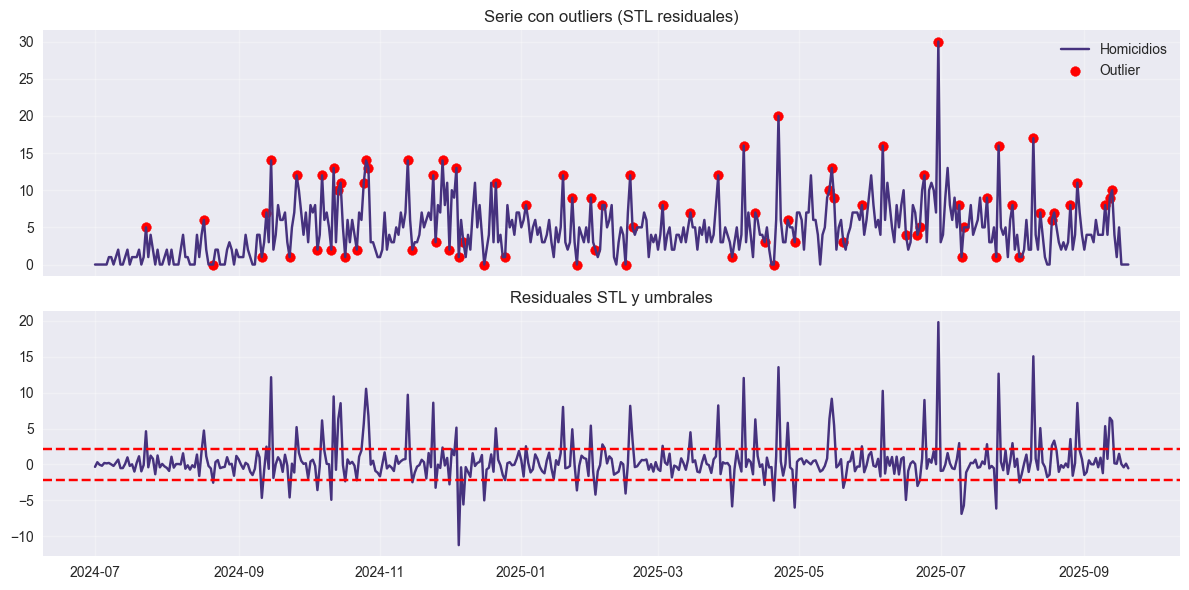

{'n_outliers': 80}


In [6]:
# 6) Detección y tratamiento de outliers con STL-residuals
from statsmodels.tsa.seasonal import STL

series = df.set_index('date')['homicidios']
if series.isna().any():
    series = series.dropna()

stl = STL(series, period=7, robust=True)
res = stl.fit()
residuals = res.resid

mad = np.median(np.abs(residuals - np.median(residuals)))
threshold = 3 * mad if mad > 0 else residuals.std() * 3
outlier_idx = residuals.index[np.abs(residuals - residuals.median()) > threshold]

# Bandera en el df principal
df['is_outlier'] = df['date'].isin(outlier_idx).astype(int)

# Plot
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax[0].plot(df['date'], df['homicidios'], label='Homicidios')
ax[0].scatter(df.loc[df['is_outlier']==1,'date'], df.loc[df['is_outlier']==1,'homicidios'], color='r', label='Outlier')
ax[0].set_title('Serie con outliers (STL residuales)'); ax[0].legend(); ax[0].grid(True, alpha=.3)
ax[1].plot(residuals.index, residuals.values)
ax[1].axhline(threshold, color='r', ls='--'); ax[1].axhline(-threshold, color='r', ls='--')
ax[1].set_title('Residuales STL y umbrales'); ax[1].grid(True, alpha=.3)
plt.tight_layout(); plt.show()

print({'n_outliers': int(df['is_outlier'].sum())})

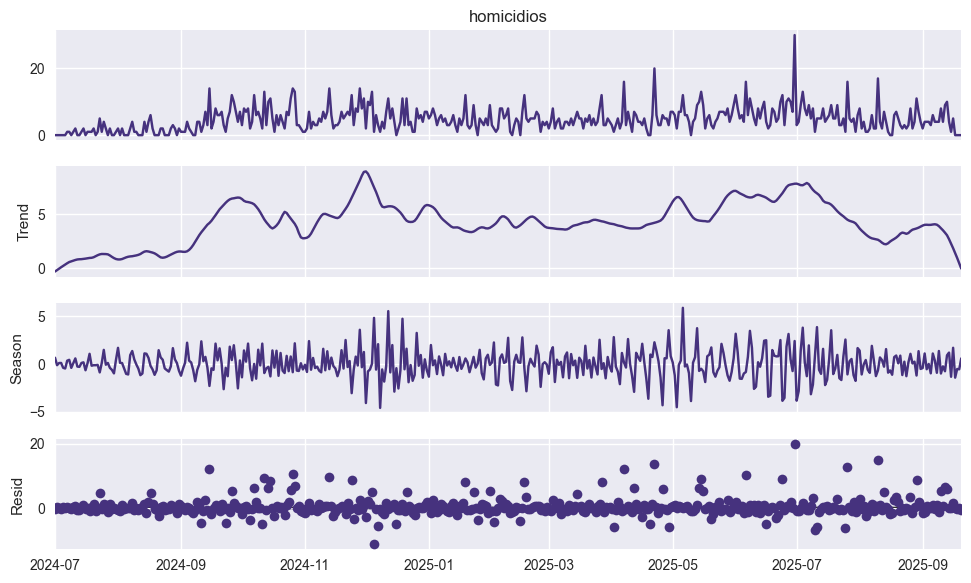

{'amplitud_semanal_media': 6.887640071580831, 'variacion_mensual_media': 1.9389029973973635}


In [7]:
# 7) Descomposición STL y análisis de estacionalidad
from statsmodels.tsa.seasonal import STL

stl = STL(series, period=7, robust=True)
res = stl.fit()
fig = res.plot(); fig.set_size_inches(10,6); plt.show()

# Métricas de estacionalidad semanal
weekly_amp = res.seasonal.groupby(res.seasonal.index.dayofweek).apply(lambda s: s.max()-s.min()).mean()
monthly_var = series.groupby(series.index.month).mean().var()
print({'amplitud_semanal_media': float(weekly_amp), 'variacion_mensual_media': float(monthly_var)})

In [8]:
# 8) Tests de estacionariedad (ADF/KPSS) y transformaciones opcionales
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import PowerTransformer

s = series.dropna()

adf_stat, adf_p, *_ = adfuller(s, autolag='AIC')
try:
    kpss_stat, kpss_p, *_ = kpss(s, regression='c', nlags='auto')
except Exception:
    kpss_stat, kpss_p = np.nan, np.nan
print({'ADF_pvalue': float(adf_p), 'KPSS_pvalue': float(kpss_p) if not np.isnan(kpss_p) else None})

# Yeo-Johnson en análisis (no para entrenar Poisson directamente)
pt = PowerTransformer(method='yeo-johnson', standardize=True)
try:
    s_yj = pd.Series(pt.fit_transform(s.values.reshape(-1,1)).ravel(), index=s.index)
    print({'YJ_mean': float(s_yj.mean()), 'YJ_std': float(s_yj.std())})
except Exception as e:
    print('Yeo-Johnson no aplicado:', e)

{'ADF_pvalue': 0.05358736639219222, 'KPSS_pvalue': 0.01}
{'YJ_mean': 1.5895810643402688e-17, 'YJ_std': 1.001120448530729}


C:\Users\carlo\AppData\Local\Temp\ipykernel_37100\4116156050.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression='c', nlags='auto')


In [9]:
# 9) Ingeniería de características estrictamente causales
Xy = df.copy()

# Lags de homicidios
for lag in [1,2,3,7,14,28]:
    Xy[f'h_lag_{lag}'] = Xy['homicidios'].shift(lag)

# Rolling shifted(1)
for w in [3,7,14,28]:
    Xy[f'h_roll_mean_{w}'] = Xy['homicidios'].shift(1).rolling(w, min_periods=2).mean()
    Xy[f'h_roll_std_{w}']  = Xy['homicidios'].shift(1).rolling(w, min_periods=2).std()
    Xy[f'h_roll_max_{w}']  = Xy['homicidios'].shift(1).rolling(w, min_periods=2).max()
    Xy[f'h_roll_min_{w}']  = Xy['homicidios'].shift(1).rolling(w, min_periods=2).min()

# Clima
if {'tmax','tmin'}.issubset(Xy.columns):
    Xy['amplitud_termica'] = Xy['tmax'] - Xy['tmin']
Xy['llueve'] = (Xy.get('prcp', 0) > 0).astype(int)
Xy['lluvia_fuerte'] = (Xy.get('prcp', 0) >= 10).astype(int)

# Económicas
if 'precio_dolar' in Xy.columns:
    Xy['dolar_ret'] = Xy['precio_dolar'].pct_change().replace([np.inf,-np.inf], np.nan)

# Robos (otra serie de conteo)
if 'robos' in Xy.columns:
    for lag in [1,7,14]:
        Xy[f'robos_lag_{lag}'] = Xy['robos'].shift(lag)

# Calendario
if 'dia_semana' in Xy.columns:
    Xy = Xy.join(pd.get_dummies(Xy['dia_semana'], prefix='dow'))
if 'es_fin_semana' in Xy.columns:
    # Convertir a 0/1 manejando posibles None
    Xy['es_fin_semana'] = Xy['es_fin_semana'].fillna(False).astype(int)
for col in ['inicio_mes','fin_mes','es_dia_pago','es_festivo','despues_festivo','antes_festivo','has_event']:
    if col in Xy.columns:
        Xy[col] = Xy[col].fillna(0).astype(int)

print('Shape con features causales:', Xy.shape)
Xy.head(3)

Shape con features causales: (447, 63)


,date,homicidios,homicidios_ma7,homicidios_ma30,robos,tavg,tmin,tmax,prcp,wspd,pres,precio_dolar,año,mes,dia,dia_semana_num,quincena,dias_desde_pago,has_event,dia_semana,es_fin_semana,es_dia_pago,es_festivo,es_dia_habil,despues_festivo,antes_festivo,is_outlier,h_lag_1,h_lag_2,h_lag_3,h_lag_7,h_lag_14,h_lag_28,h_roll_mean_3,h_roll_std_3,h_roll_max_3,h_roll_min_3,h_roll_mean_7,h_roll_std_7,h_roll_max_7,h_roll_min_7,h_roll_mean_14,h_roll_std_14,h_roll_max_14,h_roll_min_14,h_roll_mean_28,h_roll_std_28,h_roll_max_28,h_roll_min_28,amplitud_termica,llueve,lluvia_fuerte,dolar_ret,robos_lag_1,robos_lag_7,robos_lag_14,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,2024-07-01,0.0,0.714286,1.1,0.0,29.4,24.7,35.1,0.0,7.6,1012.7,19.940201,2024.0,7.0,1.0,0.0,1.0,0.0,0,Monday,0,1,0,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.4,0,0,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False
1,2024-07-02,0.0,0.714286,1.1,0.0,29.4,24.7,35.1,0.0,7.6,1012.7,19.940201,2024.0,7.0,2.0,1.0,1.0,1.0,0,Tuesday,0,0,0,True,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.4,0,0,0.0,0.0,NaN,NaN,False,False,False,False,False,True,False
2,2024-07-03,0.0,0.714286,1.1,0.0,29.4,24.7,35.1,0.0,7.6,1012.7,19.940201,2024.0,7.0,3.0,2.0,1.0,2.0,0,Wednesday,0,0,0,True,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.4,0,0,0.0,0.0,NaN,NaN,False,False,False,False,False,False,True


In [10]:
# 10) Backtesting walk-forward con ventana y gap anti-fuga
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mape_trunc(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom))

def walk_forward_backtest(model, X, y, dates, n_splits=6, train_window=120, test_window=14, gap=7):
    results = []
    start = 0
    while True:
        train_end = start + train_window
        gap_end = train_end + gap
        test_end = gap_end + test_window
        if test_end > len(X):
            break
        Xtr, ytr = X.iloc[start:train_end], y.iloc[start:train_end]
        Xte, yte = X.iloc[gap_end:test_end], y.iloc[gap_end:test_end]
        dte = dates.iloc[gap_end:test_end]
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        res = {
            'start': dates.iloc[start],
            'train_end': dates.iloc[train_end-1],
            'test_start': dte.iloc[0],
            'test_end': dte.iloc[-1],
            'MAE': mean_absolute_error(yte, pred),
            'RMSE': np.sqrt(mean_squared_error(yte, pred)),
            'R2': r2_score(yte, pred),
            'MAPE_trunc': mape_trunc(yte, pred)
        }
        results.append(res)
        start += test_window  # avanzar ventana
    return pd.DataFrame(results)

In [11]:
# 11) Modelos y evaluación comparativa
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Construir X e y a partir de Xy (definido en la celda 9)
# Usamos solo columnas numéricas y eliminamos filas con NaN debidos a lags/rolling
feature_cols = [c for c in Xy.columns if c not in ['date', 'homicidios']]
feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(Xy[c])]
X_tmp = Xy[feature_cols].copy()
y_tmp = Xy['homicidios'].copy()
mask = y_tmp.notna()
X_tmp = X_tmp[mask]
y_tmp = y_tmp[mask]
X = X_tmp.dropna()
y = y_tmp.loc[X.index]

# Columnas numéricas para posible escalado
numeric_cols = X.columns.tolist()

# Definición de modelos
models = {
    'Poisson': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('est', PoissonRegressor(alpha=1e-2, max_iter=1000))
    ]),
    'NegBin_approx': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('est', TweedieRegressor(power=1.5, alpha=1e-3, max_iter=1000))
    ]),
    'RF': RandomForestRegressor(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1),
}

# Modelos de cuantiles para intervalos (inferior/superior)
quantile_models = {
    'q10': GradientBoostingRegressor(loss='quantile', alpha=0.10, random_state=42),
    'q50': GradientBoostingRegressor(loss='quantile', alpha=0.50, random_state=42),
    'q90': GradientBoostingRegressor(loss='quantile', alpha=0.90, random_state=42),
}


def evaluate_models_backtest(models, X, y, dates, train_window=180, test_window=14, gap=7):
    all_results = []
    for name, mdl in models.items():
        res = walk_forward_backtest(mdl, X, y, dates,
                                    n_splits=None,
                                    train_window=train_window,
                                    test_window=test_window,
                                    gap=gap)
        res['model'] = name
        all_results.append(res)
    return pd.concat(all_results, ignore_index=True)

print('Modelos definidos:', list(models.keys()))

Modelos definidos: ['Poisson', 'NegBin_approx', 'RF']


In [12]:
# 12) Ejecutar backtesting y comparar métricas
results_bt = evaluate_models_backtest(models, X, y, df.index.to_series(),
                                      train_window=200, test_window=14, gap=7)

grp = results_bt.groupby('model').agg({
    'MAE': 'mean', 'RMSE': 'mean', 'R2': 'mean', 'MAPE_trunc': 'mean'
}).sort_values('MAE')
print(grp)

best_model_name = grp.index[0]
print('Mejor modelo por MAE:', best_model_name)

# Entrenar mejor modelo en todo el periodo menos las últimas 14 días (ejemplo) y evaluar
holdout = 14
mdl = models[best_model_name]
Xtr, ytr = X.iloc[:-holdout], y.iloc[:-holdout]
Xho, yho = X.iloc[-holdout:], y.iloc[-holdout:]
mdl.fit(Xtr, ytr)
yhat_ho = mdl.predict(Xho)
print('Holdout MAE:', mean_absolute_error(yho, yhat_ho),
      'RMSE:', np.sqrt(mean_squared_error(yho, yhat_ho)))

                    MAE      RMSE        R2     MAPE_trunc
model                                                     
RF             2.187452  2.873739  0.194342  152952.949189
NegBin_approx  2.901258  3.683702 -0.657647  126645.556559
Poisson        2.938194  3.756339 -0.791341  115922.353188
Mejor modelo por MAE: RF
Holdout MAE: 1.5435714285714286 RMSE: 1.7511529365371996
Holdout MAE: 1.5435714285714286 RMSE: 1.7511529365371996


In [13]:
# 13) Intervalos de predicción con modelos de cuantiles

def quantile_backtest(quantile_models, X, y, dates, train_window=200, test_window=14, gap=7):
    preds = []
    start = 0
    while True:
        train_end = start + train_window
        gap_end = train_end + gap
        test_end = gap_end + test_window
        if test_end > len(X):
            break
        Xtr, ytr = X.iloc[start:train_end], y.iloc[start:train_end]
        Xte, yte = X.iloc[gap_end:test_end], y.iloc[gap_end:test_end]
        dte = dates.iloc[gap_end:test_end]
        fitted = {}
        for qname, qmdl in quantile_models.items():
            qmdl.fit(Xtr, ytr)
            fitted[qname] = qmdl.predict(Xte)
        dfp = pd.DataFrame({'date': dte.values,
                            'y_true': yte.values,
                            'q10': fitted['q10'],
                            'q50': fitted['q50'],
                            'q90': fitted['q90']})
        preds.append(dfp)
        start += test_window
    return pd.concat(preds, ignore_index=True)

q_preds = quantile_backtest(quantile_models, X, y, df.index.to_series(),
                            train_window=200, test_window=14, gap=7)

# Cobertura y ancho promedio
coverage = np.mean((q_preds['y_true'] >= q_preds['q10']) & (q_preds['y_true'] <= q_preds['q90']))
width = np.mean(q_preds['q90'] - q_preds['q10'])
print('Cobertura 80% esperada ~0.80, observada:', round(coverage,3))
print('Ancho promedio del intervalo:', round(width,3))

Cobertura 80% esperada ~0.80, observada: 0.79
Ancho promedio del intervalo: 6.159


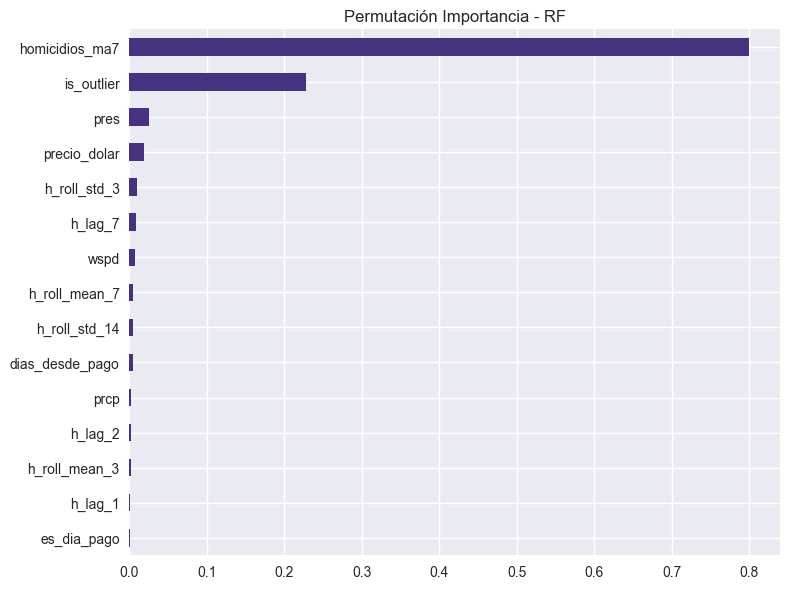

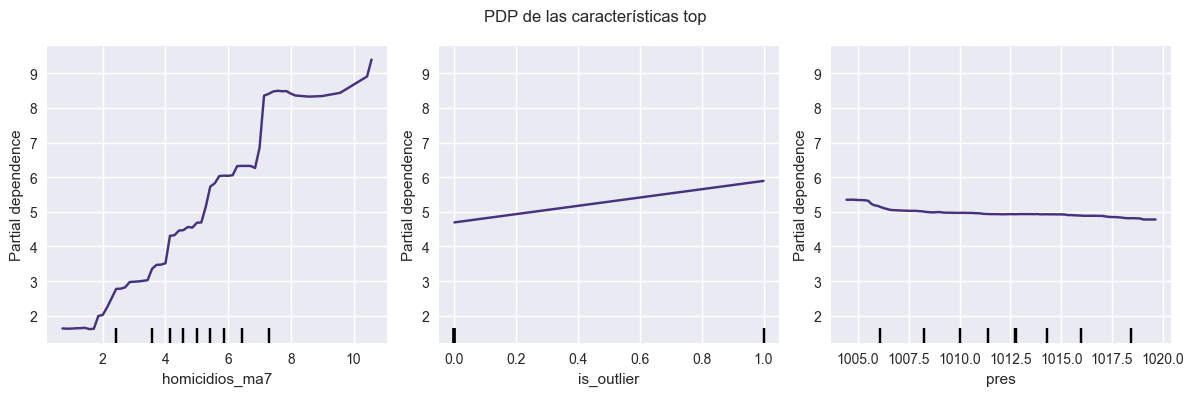

In [14]:
# 14) Importancias y PDP/ICE del mejor modelo
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Usamos el holdout ya calculado en la sección 12
try:
    imp = permutation_importance(mdl, Xho, yho, n_repeats=10, random_state=42, n_jobs=-1)
    importances = pd.Series(imp.importances_mean, index=X.columns).sort_values(ascending=False)
    topk = importances.head(15)
    plt.figure(figsize=(8,6))
    topk.iloc[::-1].plot(kind='barh')
    plt.title(f'Permutación Importancia - {best_model_name}')
    plt.tight_layout()
    plt.show()

    # PDP para las 3 características más importantes
    from sklearn.inspection import PartialDependenceDisplay
    top3 = topk.index[:3].tolist()
    fig, ax = plt.subplots(1, min(3, len(top3)), figsize=(12,4))
    PartialDependenceDisplay.from_estimator(mdl, Xtr, features=top3[:3], ax=ax)
    plt.suptitle('PDP de las características top')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('No se pudo calcular importancias/PDP:', e)

In [15]:
#

In [16]:
# 16) Chequeos de drift (PSI y KS)
from scipy.stats import ks_2samp

def psi(expected, actual, buckets=10):
    exp, act = pd.Series(expected), pd.Series(actual)
    qs = np.linspace(0,1,buckets+1)
    bins = np.unique(np.quantile(pd.concat([exp, act]), qs))
    e_counts, _ = np.histogram(exp, bins=bins)
    a_counts, _ = np.histogram(act, bins=bins)
    e_perc = (e_counts / max(e_counts.sum(), 1)).clip(1e-6)
    a_perc = (a_counts / max(a_counts.sum(), 1)).clip(1e-6)
    return float(np.sum((a_perc - e_perc) * np.log(a_perc / e_perc)))

split = len(X) // 2
X_early, X_late = X.iloc[:split], X.iloc[-split:]
psi_scores = {}
ks_pvals = {}
for col in X.columns[:20]:  # limitar a 20 primeras por brevedad
    try:
        psi_scores[col] = psi(X_early[col].values, X_late[col].values)
        ks_pvals[col] = ks_2samp(X_early[col].values, X_late[col].values).pvalue
    except Exception:
        continue

psi_top = sorted(psi_scores.items(), key=lambda x: -x[1])[:10]
print('Top 10 PSI (mayor drift):', psi_top)
ks_top = sorted(ks_pvals.items(), key=lambda x: x[1])[:10]
print('Top 10 KS (p más bajo):', ks_top)

Top 10 PSI (mayor drift): [('mes', 14.801285914435757), ('tmax', 6.057484478778701), ('precio_dolar', 5.746379944797563), ('homicidios_ma30', 5.34128069364572), ('tavg', 4.025716040835109), ('tmin', 2.2047861740400276), ('robos', 1.385873838549497), ('wspd', 0.4752074309556272), ('homicidios_ma7', 0.4511237527626884), ('pres', 0.3134653664013595)]
Top 10 KS (p más bajo): [('año', np.float64(4.73246294306253e-57)), ('precio_dolar', np.float64(2.5776879092991584e-33)), ('robos', np.float64(4.736804157313878e-31)), ('tmax', np.float64(7.880820996748895e-25)), ('tavg', np.float64(6.146081504868871e-23)), ('mes', np.float64(6.146081504868871e-23)), ('tmin', np.float64(1.7698438407539064e-22)), ('homicidios_ma30', np.float64(7.561654401589017e-05)), ('wspd', np.float64(0.0009199774362853702)), ('homicidios_ma7', np.float64(0.0013474963623911493))]


In [17]:
# 17) Exportes finales: dataset, features y modelo
from pathlib import Path
from joblib import dump
import json

out_dir = Path('../modelos')
out_dir.mkdir(parents=True, exist_ok=True)

# Exportar dataset con features
out_df = df.copy()
out_df[list(X.columns)] = X
out_df['target'] = y
out_path = out_dir / 'dataset_features_procesado.csv'
out_df.to_csv(out_path, index=True)
print('Dataset con features guardado en:', out_path)

# Entrenar mejor modelo en todo el set y exportar
mdl_full = models[best_model_name]
mdl_full.fit(X, y)
model_path = out_dir / f'modelo_{best_model_name}_full.joblib'
dump(mdl_full, model_path)
print('Modelo guardado en:', model_path)

meta = {
    'best_model': best_model_name,
    'n_rows': int(len(df)),
    'n_features': int(X.shape[1]),
    'train_window': 200,
    'test_window': 14,
    'gap': 7,
    'columns': X.columns.tolist()
}
meta_path = out_dir / f'modelo_{best_model_name}_meta.json'
with open(meta_path, 'w', encoding='utf-8') as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print('Metadatos guardados en:', meta_path)

Dataset con features guardado en: ..\modelos\dataset_features_procesado.csv
Modelo guardado en: ..\modelos\modelo_RF_full.joblib
Metadatos guardados en: ..\modelos\modelo_RF_meta.json
Modelo guardado en: ..\modelos\modelo_RF_full.joblib
Metadatos guardados en: ..\modelos\modelo_RF_meta.json


In [27]:
from joblib import load

# Predicción de homicidios para una fecha específica
# Ajusta esta fecha en formato YYYY-MM-DD
desired_date_str = '2025-09-17'  # <-- cambia aquí si deseas otra fecha

# Fecha objetivo (si no se define, usar día siguiente al último del df)
if desired_date_str:
    target_date = pd.to_datetime(desired_date_str)
else:
    target_date = df['date'].max() + pd.Timedelta(days=1)

# Historial hasta el día anterior a la fecha objetivo (estrictamente pasado)
hist = df[df['date'] < target_date].copy()

# Series base del historial
s_h = hist['homicidios'].astype(float) if 'homicidios' in hist.columns else pd.Series(dtype=float)
s_r = hist['robos'].ffill() if 'robos' in hist.columns else pd.Series(index=hist.index, dtype=float)

# Exógenas (último valor conocido ANTES de target_date)
base_cols = ['robos','tavg','tmin','tmax','prcp','wspd','pres','precio_dolar']
base_vals = {c: (hist[c].ffill().iloc[-1] if (c in hist.columns and len(hist[c].dropna())) else np.nan) for c in base_cols}

# Evento (si existe en events_df) para el día objetivo
has_event_val = 0
if 'events_df' in globals() and isinstance(events_df, pd.DataFrame) and 'date' in events_df:
    ev = events_df.dropna(subset=['date']).copy()
    ev['date'] = pd.to_datetime(ev['date']).dt.normalize()
    has_event_val = int(ev['date'].eq(target_date.normalize()).any())

# Calendario básico (si cal_df tiene info para esa fecha, úsala; si no, fallback derivado)
cal_vals = {
    'año': target_date.year,
    'mes': target_date.month,
    'dia': target_date.day,
    'dia_semana_num': target_date.weekday(),
    'quincena': 1 if target_date.day <= 15 else 2,
    'dias_desde_pago': (target_date.day - 1) if target_date.day <= 15 else (target_date.day - 15),
    'es_fin_semana': int(target_date.weekday() >= 5),
    'es_dia_pago': 1 if target_date.day in [1, 15] else 0,
    'es_festivo': 0,
    'despues_festivo': 0,
    'antes_festivo': 0,
}
if 'cal_df' in globals() and isinstance(cal_df, pd.DataFrame) and 'date' in cal_df:
    c = cal_df[pd.to_datetime(cal_df['date']).dt.normalize() == target_date.normalize()]
    if len(c):
        for k in ['año','mes','dia','dia_semana_num','quincena','dias_desde_pago',
                  'es_fin_semana','es_dia_pago','es_festivo','despues_festivo','antes_festivo']:
            if k in c.columns:
                # flags como int, otros como float
                val = c.iloc[0][k]
                cal_vals[k] = int(val) if (k.startswith('es_') or k in ['quincena','dia_semana_num']) else float(val)

# Lags de homicidios a partir del historial
lags = {f'h_lag_{lag}': (float(s_h.iloc[-lag]) if len(s_h) >= lag else np.nan) for lag in [1,2,3,7,14,28]}

# Rollings (estadísticos de los últimos w días hasta t=target_date-1)
def roll_stats(series, w):
    tail = series.tail(w)
    return {
        f'h_roll_mean_{w}': float(tail.mean()) if len(tail) else np.nan,
        f'h_roll_std_{w}': float(tail.std()) if len(tail) else np.nan,
        f'h_roll_max_{w}': float(tail.max()) if len(tail) else np.nan,
        f'h_roll_min_{w}': float(tail.min()) if len(tail) else np.nan,
    }
rolls = {}
for w in [3,7,14,28]:
    rolls.update(roll_stats(s_h, w))

# MA7/MA30 (promedios simples de últimos días del historial)
ma_feats = {
    'homicidios_ma7': float(s_h.tail(7).mean()) if len(s_h) >= 1 else np.nan,
    'homicidios_ma30': float(s_h.tail(30).mean()) if len(s_h) >= 1 else np.nan,
}

# Robos lags desde historial
robos_lags = {}
if len(s_r):
    if len(s_r) >= 1: robos_lags['robos_lag_1'] = float(s_r.iloc[-1])
    if len(s_r) >= 7: robos_lags['robos_lag_7'] = float(s_r.iloc[-7])
    if len(s_r) >= 14: robos_lags['robos_lag_14'] = float(s_r.iloc[-14])

# Derivadas clima/económicas desde base_vals (historial)
amplitud_termica = (base_vals.get('tmax', np.nan) - base_vals.get('tmin', np.nan))
prcp_val = base_vals.get('prcp', 0.0)
derived = {
    'amplitud_termica': float(amplitud_termica) if pd.notna(amplitud_termica) else np.nan,
    'llueve': int(prcp_val > 0),
    'lluvia_fuerte': int(prcp_val >= 10),
    'dolar_ret': 0.0,  # desconocido para t+1
    'is_outlier': 0,
    'has_event': has_event_val,
}

# Dummies de día de semana (por si el modelo las tiene)
dow_name = target_date.day_name()
dows = {f'dow_{name}': int(name == dow_name) for name in
        ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']}

# Armar fila futura con todas las features esperadas por el modelo
row = {}
row.update(base_vals)
row.update(cal_vals)
row.update(lags)
row.update(rolls)
row.update(ma_feats)
row.update(robos_lags)
row.update(derived)
row.update(dows)

# Alinear con columnas del modelo y rellenar faltantes con 0.0
X_future = pd.DataFrame([{col: row.get(col, 0.0) for col in X.columns}], columns=X.columns).astype(float)
X_future = X_future.fillna(0.0)

# Modelo (usar mdl_full si existe; si no, cargar desde disco)
try:
    model = mdl_full
except NameError:
    model = load(model_path)

pred = float(model.predict(X_future)[0])
print({'fecha': str(target_date.date()), 'pred_homicidios': round(pred, 3)})

{'fecha': '2025-09-17', 'pred_homicidios': 5.133}


In [20]:
# 18) Preparación de datos para LSTM (ventanas)
import numpy as np
import pandas as pd

# Usaremos las features numéricas ya construidas en X (sección 11)
# y el target y (homicidios). Si no existen, recrearlos desde Xy.
try:
    X_lstm = X.copy()
    y_lstm = y.copy()
except NameError:
    feature_cols = [c for c in Xy.columns if c not in ['date', 'homicidios']]
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(Xy[c])]
    X_tmp = Xy[feature_cols].copy()
    y_tmp = Xy['homicidios'].copy()
    mask = y_tmp.notna()
    X_lstm = X_tmp[mask].dropna()
    y_lstm = y_tmp.loc[X_lstm.index]

# Normalización simple (min-max por columna) para estabilizar el entrenamiento
# Asegurar tipo float para evitar resta booleana (bool - bool no soportado)
X_lstm = X_lstm.astype(float)

X_min = X_lstm.min()
X_max = X_lstm.max()
X_range = (X_max - X_min).replace(0, 1)
X_scaled = (X_lstm - X_min) / X_range


def build_sequences(Xdf, yser, window, horizon=1):
    """Convierte una serie de features Xdf y target yser en secuencias para LSTM.
    X: (n_samples, window, n_features), y: (n_samples,)"""
    Xarr, yarr, idx = [], [], []
    for i in range(window, len(Xdf) - horizon + 1):
        Xarr.append(Xdf.iloc[i-window:i].values)
        yarr.append(float(yser.iloc[i + horizon - 1]))
        idx.append(i + horizon - 1)
    Xarr = np.asarray(Xarr, dtype=np.float32)
    yarr = np.asarray(yarr, dtype=np.float32)
    return Xarr, yarr, idx

print('Datos LSTM listos. n_features =', X_scaled.shape[1])

Datos LSTM listos. n_features = 59


In [21]:
# 19) Modelo LSTM (Keras) y utilidades de entrenamiento
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def make_lstm_model(n_features: int, units: int = 64, dropout: float = 0.2):
    inp = keras.Input(shape=(None, n_features))
    x = layers.Masking(mask_value=0.0)(inp)
    x = layers.LSTM(units, return_sequences=False)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='relu')(x)  # homicidios >= 0
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mae')
    return model


def train_lstm(Xseq, yseq, epochs=30, batch_size=32, patience=5, verbose=0):
    n_features = Xseq.shape[-1]
    model = make_lstm_model(n_features)
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
    # Simple split: last 10% as validation
    n = len(Xseq)
    n_val = max(1, int(0.1 * n))
    Xtr, ytr = Xseq[:-n_val], yseq[:-n_val]
    Xva, yva = Xseq[-n_val:], yseq[-n_val:]
    history = model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
    return model, history

In [23]:
# 20) Backtesting LSTM: comparar ventanas 28 vs 365 días
from sklearn.metrics import mean_absolute_error, mean_squared_error


def lstm_walk_forward(X_scaled, y_series, window, test_window=14, gap=7, epochs=25, verbose=0):
    Xseq, yseq, idx = build_sequences(X_scaled, y_series, window=window, horizon=1)
    results = []
    start = 0
    while True:
        train_end = start + max(120, 3*window)
        gap_end = train_end + gap
        test_end = gap_end + test_window
        if test_end > len(Xseq):
            break
        Xtr, ytr = Xseq[start:train_end], yseq[start:train_end]
        Xte, yte = Xseq[gap_end:test_end], yseq[gap_end:test_end]
        model, _ = train_lstm(Xtr, ytr, epochs=epochs, verbose=verbose)
        pred = model.predict(Xte, verbose=0).ravel()
        res = {
            'window': window,
            'MAE': mean_absolute_error(yte, pred),
            'RMSE': float(np.sqrt(mean_squared_error(yte, pred))),
        }
        results.append(res)
        start += test_window
    return pd.DataFrame(results)

# Ejecutar comparativa
win_short = 28
win_long = 365
res_short = lstm_walk_forward(X_scaled, y_lstm.reset_index(drop=True), window=win_short, epochs=30, verbose=0)
res_long = lstm_walk_forward(X_scaled, y_lstm.reset_index(drop=True), window=win_long, epochs=10, verbose=0)

# Resumen robusto ante DataFrames vacíos
frames = []
if isinstance(res_short, pd.DataFrame) and not res_short.empty and 'window' in res_short.columns:
    frames.append(res_short.groupby('window').agg({'MAE': 'mean', 'RMSE': 'mean'}))
if isinstance(res_long, pd.DataFrame) and not res_long.empty and 'window' in res_long.columns:
    frames.append(res_long.groupby('window').agg({'MAE': 'mean', 'RMSE': 'mean'}))

if len(frames) == 0:
    print('Comparación LSTM: no hay resultados suficientes (pocas muestras para las ventanas seleccionadas).')
    summary = pd.DataFrame(columns=['MAE', 'RMSE'])
    best_win = None
else:
    summary = pd.concat(frames).sort_values('MAE')
    best_win = int(summary.index[0])

print('Comparación LSTM (menor es mejor):')
print(summary)
print('Mejor ventana LSTM:', best_win)

Comparación LSTM (menor es mejor):
             MAE      RMSE
window                    
28      2.475946  3.327649
Mejor ventana LSTM: 28


In [36]:
# 21) Predicción LSTM para una fecha específica (sin fuga)
# Configuración de fecha y ventana
pred_date_str = '2025-09-16'   # <--- cambia la fecha aquí
lstm_window = 28               # usa 28 o 365 para comparar

pred_date = pd.to_datetime(pred_date_str)

# Filtrar historial estrictamente anterior a la fecha objetivo
mask_hist = df['date'] < pred_date
if mask_hist.sum() < max(120, 3*lstm_window):
    raise ValueError('No hay suficiente historial antes de la fecha objetivo para entrenar el LSTM.')

# Reconstruir X_lstm/y_lstm y su escala usando solo historial previo
feature_cols = X.columns.tolist()
# Alinear la máscara temporal con los índices de X/y (evita 447 vs 419)
dates_aligned = df.loc[X.index, 'date']
mask_hist_X = dates_aligned < pred_date
X_hist = X.loc[mask_hist_X].astype(float)
y_hist = y.loc[mask_hist_X].astype(float)

X_min_h = X_hist.min()
X_max_h = X_hist.max()
X_range_h = (X_max_h - X_min_h).replace(0, 1)
X_scaled_h = (X_hist - X_min_h) / X_range_h

# Secuencias con la ventana elegida
Xseq, yseq, idx = build_sequences(X_scaled_h.reset_index(drop=True), y_hist.reset_index(drop=True), window=lstm_window, horizon=1)

# Entrenar el LSTM con early stopping
model_lstm, _ = train_lstm(Xseq, yseq, epochs=40, verbose=0)

# Construir la secuencia más reciente (últimos `lstm_window` días) hasta el día t = pred_date - 1
X_last_window = X_scaled_h.iloc[-lstm_window:].values.astype('float32')
X_last_window = np.expand_dims(X_last_window, axis=0)  # shape (1, window, n_features)

pred_lstm = float(model_lstm.predict(X_last_window, verbose=0).ravel()[0])
print({'fecha': pred_date_str, 'pred_homicidios_LSTM': round(pred_lstm, 3), 'ventana': lstm_window})

{'fecha': '2025-09-16', 'pred_homicidios_LSTM': 4.39, 'ventana': 28}
